In [130]:
import pandas as pd
import pyarrow.feather as feather
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import requests
from sklearn.manifold import TSNE

from src.load_data import *
from src.graph_data import *
from src.utils import *

In [131]:
#%pip install -r requirements.txt

# Part 0 : Data Handling 

Here, we have rearranged the data making it easier to work with. We have split the data up into two data frames described as follows :


## Article DF
| Article | Category | linkTargets | Article_id | distances | plain_text | 
| ------- | ---------- | ------------ | ---------- | ---------- | ---------- |
| string | string | list[string] | string | dict[string, int] | string | 


## Path DF
| Path | uid | start_article | target_article | length | finished | distance | rating | reason of fail |
| ------- | ---------- | ------------ | ---------- | ---------- | ---------- | ----- | ---- | ------ |
| list[string] | string | string | string | int  | boolean | int | int | string |

In [132]:
# create the directory `Data/dataframes`
import os
if not os.path.exists('Data/dataframes'):
    os.makedirs('Data/dataframes')

articles = load_articles_into_df()
categories = load_categories()
links = load_links()
paths_finished = load_paths_finished()
paths_unfinished = load_paths_unfinished()
distances = load_distances()

# Print the shapes of articles, categories, links
print("Articles shape: ", articles.shape)
print("Categories shape: ", categories.shape)
print("Links shape: ", links.shape)

Articles shape:  (4604, 1)
Categories shape:  (4598, 2)
Links shape:  (4587, 2)


In [133]:
# List the articles that are in articles and not in categories
articles_not_in_categories = articles[~articles['article'].isin(categories['article'])]
# List the articles that are in articles and not in link sources
articles_not_in_source_links = articles[~articles['article'].isin(links['linkSource'])]
# List the articles that are in articles and not in link targets
articles_not_in_target_links = articles[~articles['article'].isin(links['linkTarget'].explode())]

In [134]:
# Creating the article dataframe

# | Article | Category | linkTargets | Article_id | distances | plain_text | 

article_dataframe = articles

artiles_unrendered_unicode = load_articles_into_df(do_decode=False)
# Add articles_unrendered_unicode to article_dataframe
article_dataframe['article_unrendered_unicode'] = artiles_unrendered_unicode['article']

# Merge the articles and categories dataframes
article_dataframe = pd.merge(article_dataframe, categories, on='article', how='left')

# Merge the article_dataframe and links dataframes
article_dataframe = pd.merge(article_dataframe, links, left_on='article', right_on='linkSource', how='left')

# Merge the article_dataframe by inserting dictionary into `distances` column` where distances is dict[article_name, dict]
article_dataframe['distances'] = article_dataframe['article'].map(distances)

# for each row in article_dataframe, 
# load the plain_text from the file `Data/plaintext_articles/{article_name}.txt`
# here we use load_plain_text function defined in utils
article_dataframe['plain_text'] = article_dataframe['article_unrendered_unicode'].apply(load_plain_text)

article_dataframe.to_feather('Data/dataframes/article_dataframe.feather')

In [135]:
# Creating the paths dataframe

# | Path | uid | start_article | target_article | length | finished | distance | rating | reason of fail |

# Add a "finished" column to paths_finished
paths_finished['finished'] = True
paths_finished['failure_reason'] = None
# Extract the start_article and target_article from the `path` column
paths_finished['start_article'] = paths_finished['path'].apply(lambda x: x.split(';')[0])
paths_finished['target_article'] = paths_finished['path'].apply(lambda x: x.split(';')[-1])

# Same to paths_unfinished
paths_unfinished['finished'] = False
# Clean the paths_unfinished dataframe
# Rename 'type' to 'failure_reason'
paths_unfinished.rename(columns={'type': 'failure_reason', 'target' : 'target_article'}, inplace=True)
# extract the start_article from the `path` column
paths_unfinished['start_article'] = paths_unfinished['path'].apply(lambda x: x.split(';')[0])

p = paths_unfinished[paths_unfinished['start_article'] == '<'] 

# add paths_finished and paths_unfinished together
paths = pd.concat([paths_finished, paths_unfinished])

paths.to_feather('Data/dataframes/paths.feather')

# Part 1 : Data Analysis and Exploration

## Statistical analysis of the player paths data

In [136]:
#reload stored dataframes
article_df = feather.read_feather('Data/dataframes/article_dataframe.feather')
paths_df = feather.read_feather('Data/dataframes/paths.feather')

**Before doing analysis we add some usefull columns to the data frame**
- an identifier column for the same start and target pairs
- a column where the full path is converted into a list
- a column where only the direct path (no backward clicks) are considered and converted into a list
- respectively a column for the length of the two lists (path legths) described just above

In [137]:
# to have unique indexes
paths_df = paths_df.reset_index(drop=True)

# add an identifier for the same start-target articles pairs
paths_df['identifier'] = paths_df.groupby(['start_article', 'target_article']).ngroup()

In [138]:
# add two new columns to the paths dataset with processed paths
# here we use process_path function defined in utils

paths_df[['full_path', 'simplified_path']] = paths_df['path'].apply(lambda x: pd.Series(process_path(x)))

# also add a column of for full and simplified path length
paths_df['full_path_length'] = paths_df['full_path'].apply(lambda x: len(x)-1) # n-1 is the distance
paths_df['simplified_path_length'] = paths_df['simplified_path'].apply(lambda x: len(x)-1)

In [139]:
paths_df.head(1)

,hashedIpAddress,timestamp,durationInSec,path,rating,finished,failure_reason,start_article,target_article,identifier,full_path,simplified_path,full_path_length,simplified_path_length
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,True,None,14th_century,African_slave_trade,48,"[14th_century, 15th_century, 16th_century, Pac...","[14th_century, 15th_century, 16th_century, Pac...",8,8


In [140]:
# check if it worked for a path with backward steps
p = paths_df.loc[16]
print(f"Original String Path:\n    {p['path']}\n")
print(f"Converted Full Path:\n    {p['full_path']}\n")
print(f"Converted Simplified Path:\n    {p['simplified_path']}\n")

Original String Path:
    14th_century;Europe;Republic_of_Ireland;<;<;Europe;<;Europe;Republic_of_Ireland;<;<;Time;Physics;Speed_of_light;Rainbow

Converted Full Path:
    ['14th_century', 'Europe', 'Republic_of_Ireland', 'Europe', 'Europe', 'Republic_of_Ireland', 'Time', 'Physics', 'Speed_of_light', 'Rainbow']

Converted Simplified Path:
    ['14th_century', 'Time', 'Physics', 'Speed_of_light', 'Rainbow']



In [141]:
# apply the function that computes distance between two articles to the path data frame
# here we use get_distance_between_articles function defined in utils
paths_df['distance'] = paths_df.apply(lambda row: get_distance_between_articles(article_df, row['start_article'], row['target_article']), axis=1)


### Outlier handling
before jumping into distribution analysis let's first see if there are potential outliers that need to be taken care of, this is easier when considering finished and unfinished paths seperately

In [142]:
paths_df['full_path_length'].describe()

finished_paths = paths_df[paths_df['finished']]
unfinished_paths = paths_df[~paths_df['finished']]

print(f"Finished path length statistics:\n    {finished_paths[['full_path_length', 'simplified_path_length']].describe()}\n")
print(f"Unfinished path length statistics:\n    {unfinished_paths[['full_path_length', 'simplified_path_length']].describe()}\n")



Finished path length statistics:
           full_path_length  simplified_path_length
count      51318.000000            51318.000000
mean           5.356775                4.956117
std            3.775778                3.288758
min            0.000000                0.000000
25%            3.000000                3.000000
50%            5.000000                4.000000
75%            6.000000                6.000000
max          419.000000              404.000000

Unfinished path length statistics:
           full_path_length  simplified_path_length
count      24875.000000            24875.000000
mean           3.678915                3.160040
std            4.595089                3.942539
min            0.000000                0.000000
25%            1.000000                1.000000
50%            3.000000                2.000000
75%            5.000000                4.000000
max          191.000000              148.000000



In [143]:
# there are some very long paths lets analyse them in more detail
finished_paths.sort_values(by='full_path_length', ascending=False).head(6)

,hashedIpAddress,timestamp,durationInSec,path,rating,finished,failure_reason,start_article,target_article,identifier,full_path,simplified_path,full_path_length,simplified_path_length,distance
8046,7f6da01d55086766,1248928447,2205,"United_States;Washington,_D.C.;Government;Corp...",5.0,True,None,United_States,English_language,39775,"[United_States, Washington,_D.C., Government, ...","[United_States, Washington,_D.C., Government, ...",419,404,2.0
19961,4f1b9ce764349901,1236685130,2292,Napoleon_I_of_France;United_Kingdom;Great_Brit...,NaN,True,None,Napoleon_I_of_France,Recycling,26826,"[Napoleon_I_of_France, United_Kingdom, Great_B...","[Napoleon_I_of_France, United_Kingdom, Great_B...",113,108,3.0
6945,4e97d9af4476607f,1248925083,1141,"Police_state;Police;United_States;Washington,_...",5.0,True,None,Police_state,African_slave_trade,30473,"[Police_state, Police, United_States, Washingt...","[Police_state, Police, United_States, Washingt...",102,101,3.0
27136,0d57c8c57d75e2f5,1290096241,1852,Lake_Toba;Netherlands;Europe;Earth;United_Stat...,5.0,True,None,Lake_Toba,Looney_Tunes,22232,"[Lake_Toba, Netherlands, Europe, Earth, United...","[Lake_Toba, Netherlands, Europe, Earth, United...",90,82,4.0
6659,7f6da01d55086766,1248923237,364,North_America;Pacific_Ocean;Earth;Earth's_atmo...,5.0,True,None,North_America,Canada,27769,"[North_America, Pacific_Ocean, Earth, Earth's_...","[North_America, Pacific_Ocean, Earth, Earth's_...",71,71,1.0
28393,7b740aba73fe91e2,1231967436,171,55_Cancri_c;Saturn;Zeus;Heracles;Rome;Christia...,1.0,True,None,55_Cancri_c,Niger,456,"[55_Cancri_c, Saturn, Zeus, Heracles, Rome, Ch...","[55_Cancri_c, Saturn, Zeus, Heracles, Rome, Ch...",64,62,4.0


In [144]:
# Judjing from the actual distance between the articles the paths taken seem overly complicated and 
# where probably purposfully added
# to confirm this lets look at the statistics of some of the paths with the same identifier:

print(f"Statistics of all paths that have the same start-target article pair as the longest path:\n    {finished_paths[finished_paths['identifier'] == 39775][['full_path_length', 'simplified_path_length']].describe()}\n")

print(f"Statistics of all paths that have the same start-target article pair as the 2nd longest path:\n    {finished_paths[finished_paths['identifier'] == 26826][['full_path_length', 'simplified_path_length']].describe()}\n")


Statistics of all paths that have the same start-target article pair as the longest path:
           full_path_length  simplified_path_length
count         15.000000               15.000000
mean          29.933333               28.933333
std          107.632620              103.759658
min            2.000000                2.000000
25%            2.000000                2.000000
50%            2.000000                2.000000
75%            2.000000                2.000000
max          419.000000              404.000000

Statistics of all paths that have the same start-target article pair as the 2nd longest path:
           full_path_length  simplified_path_length
count           4.00000                4.000000
mean           35.50000               34.000000
std            52.04165               49.672259
min             3.00000                3.000000
25%             6.75000                6.750000
50%            13.00000               12.500000
75%            41.75000               3

From the above we estimate that a smart way to handle outliers is to use the interquantile range (IQR) method method removing paths which have a length of more than 75% quantile + 1.5 x IQR. There are two possible approaches either to define global outlier or to define outliers per start-target article pair group. The latter however only makes sense if there are enough samples present per group. 

Since there are certainly differences in path difficulty between the groups the second approach would be more taylored but it requires a certain number of samples per group to be somewhat accurate.  Thus we first have a look at the statistics of start-target article pair group size.

In [145]:
# Get the counts of each identifier
pair_identifier_counts = finished_paths.groupby('identifier').size()

pair_identifier_counts.describe()

count    28718.000000
mean         1.786963
std         11.128460
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1043.000000
dtype: float64

Since overall there clearly is a very low amount of sample (close to 1) per start-target pair group, we have to use the global approach (for now). 
However, this can still be adapted to path difficulty to some extend, at least for the finished paths. In fact, we can do so by consider not directly the path length but the distance between path length and optimal length (shortest possible distance from start to finish article) and apply the IQR method on it.

In [146]:
finished_paths = finished_paths.copy()

# Calculate the difference between full_path_length and distance 
# NOTE: here I use full path not direct path, which is less conservative (can be changed depending on subsequent analysis)
finished_paths['length_minus_distance'] = finished_paths['full_path_length'] - finished_paths['distance']

# Calculate Q1 and Q3 based on the new difference col
Q1 = finished_paths['length_minus_distance'].quantile(0.25)
Q3 = finished_paths['length_minus_distance'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the upper bound
upper_bound = round(Q3 + 1.5 * IQR)

# Filter the DataFrame based on the upper bound
filtered_finished_paths = finished_paths[finished_paths['length_minus_distance'] <= upper_bound]

# Calculate the number of removed rows
removed = finished_paths.shape[0] - filtered_finished_paths.shape[0]

# Print the result
print(f"A total of {removed} paths were removed, "
      f"which represents {removed / finished_paths.shape[0] * 100:.3f}% of the original data.")

# Describe the 'full_path_length' and 'simplified_path_length' columns in the filtered DataFrame
filtered_finished_paths[['full_path_length', 'simplified_path_length']].describe()


A total of 3624 paths were removed, which represents 7.062% of the original data.


,full_path_length,simplified_path_length
count,47694.000000,47694.000000
mean,4.717365,4.496289
std,1.845749,1.702182
min,0.000000,0.000000
25%,3.000000,3.000000
50%,4.000000,4.000000
75%,6.000000,5.000000
max,11.000000,11.000000


For the unfinished paths, it is not possible to simply take the difference in the same way. Here we take the full path length IQR approach for the upper bound. We set the lower bound row wise in a way to fitler out all paths that are shorter than the shortest possible path, as we estimate that there was enough effort but into those attemps from the player.

In [147]:
# do something similar for the unfinished paths but here we also put a lower bound
Q1 = unfinished_paths['full_path_length'].quantile(0.25)
Q3 = unfinished_paths['full_path_length'].quantile(0.75)
IQR = Q3 - Q1

# Upper bound based on IQR approach
upper_bound = round(Q3 + 1.5 * IQR)

# Filter the unfinished_paths based on the row's distance as the lower bound and IQR as the upper bound
filtered_unfinished_paths = unfinished_paths[
    (unfinished_paths['full_path_length'] <= upper_bound) &
    (unfinished_paths['simplified_path_length'] >= unfinished_paths['distance'])
]

removed = unfinished_paths.shape[0] - filtered_unfinished_paths.shape[0]

print(f"A total of {removed} paths were removed, "
      f"which represents {removed / unfinished_paths.shape[0] * 100:.3f}% of the original data.")

filtered_unfinished_paths[['full_path_length', 'simplified_path_length']].describe()

A total of 14674 paths were removed, which represents 58.991% of the original data.


,full_path_length,simplified_path_length
count,10201.000000,10201.000000
mean,5.382021,4.952064
std,2.261404,2.026771
min,1.000000,1.000000
25%,4.000000,3.000000
50%,5.000000,4.000000
75%,7.000000,6.000000
max,11.000000,11.000000


### Analysis of the path length distributions

We will do so starting with the finished paths. where the goal is to get a histogram of the path lengths and compute some relevant statistics.
It is interesting to look at the total number of links that where used, as well as the actual distance of the path that was taken in the end (so without considering back clicks)

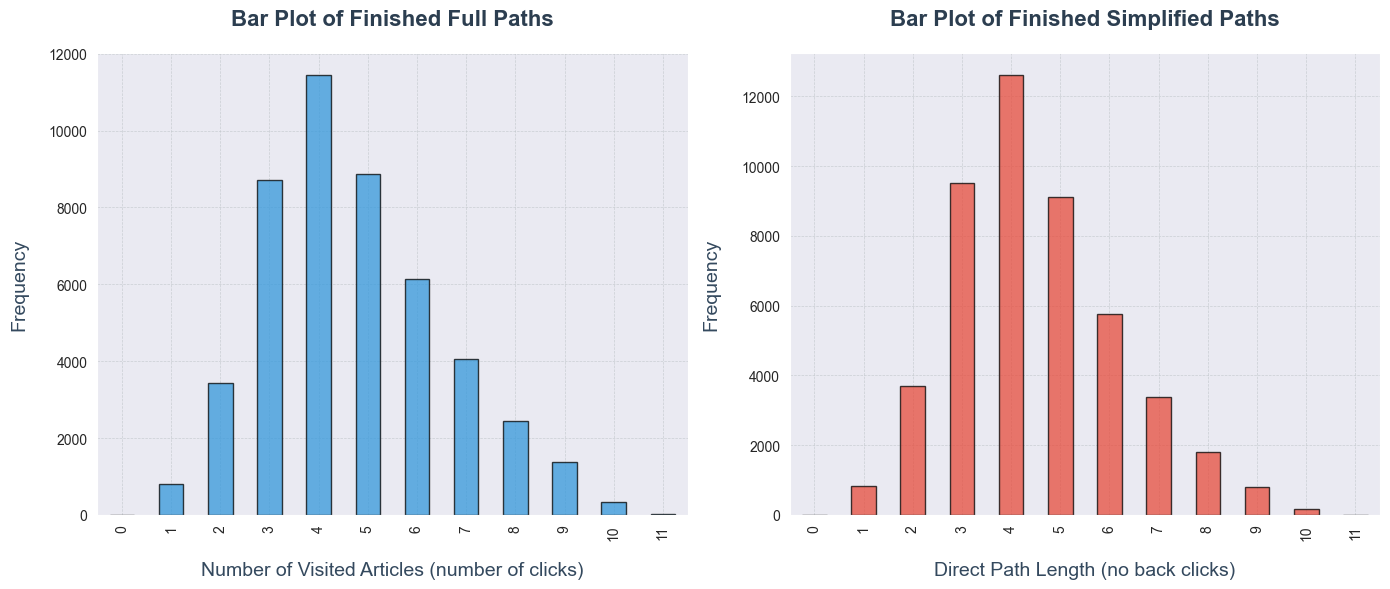

In [148]:
# Count occurrences of each path length
len_full_counts = filtered_finished_paths['full_path_length'].value_counts().sort_index()
len_simplified_counts = filtered_finished_paths['simplified_path_length'].value_counts().sort_index()

# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the bar plot for full path lengths on the first subplot
len_full_counts.plot(kind='bar', color='#3498db', edgecolor='black', alpha=0.75, ax=axes[0])
axes[0].set_title("Bar Plot of Finished Full Paths", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
axes[0].set_xlabel("Number of Visited Articles (number of clicks)", fontsize=14, color='#34495E', labelpad=15)
axes[0].set_ylabel("Frequency", fontsize=14, color='#34495E', labelpad=15)
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')  # Subtle gridlines

# Plot the bar plot for simplified path lengths on the second subplot
len_simplified_counts.plot(kind='bar', color='#e74c3c', edgecolor='black', alpha=0.75, ax=axes[1])
axes[1].set_title("Bar Plot of Finished Simplified Paths", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
axes[1].set_xlabel("Direct Path Length (no back clicks)", fontsize=14, color='#34495E', labelpad=15)
axes[1].set_ylabel("Frequency", fontsize=14, color='#34495E', labelpad=15)
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')  # Subtle gridlines

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()



This looks pretty good! The cutoff seems reasonable. However, there are certain samples with '0' path length inbetween them. they need to be taken care of.

In [149]:
# we notice that there are some samples with distance 0 (start and target article are the same).
# these also need to be filtered out

filtered_finished_paths = filtered_finished_paths[~(filtered_finished_paths['distance']== 0)]

We now display the distribution of the unfinished articles.

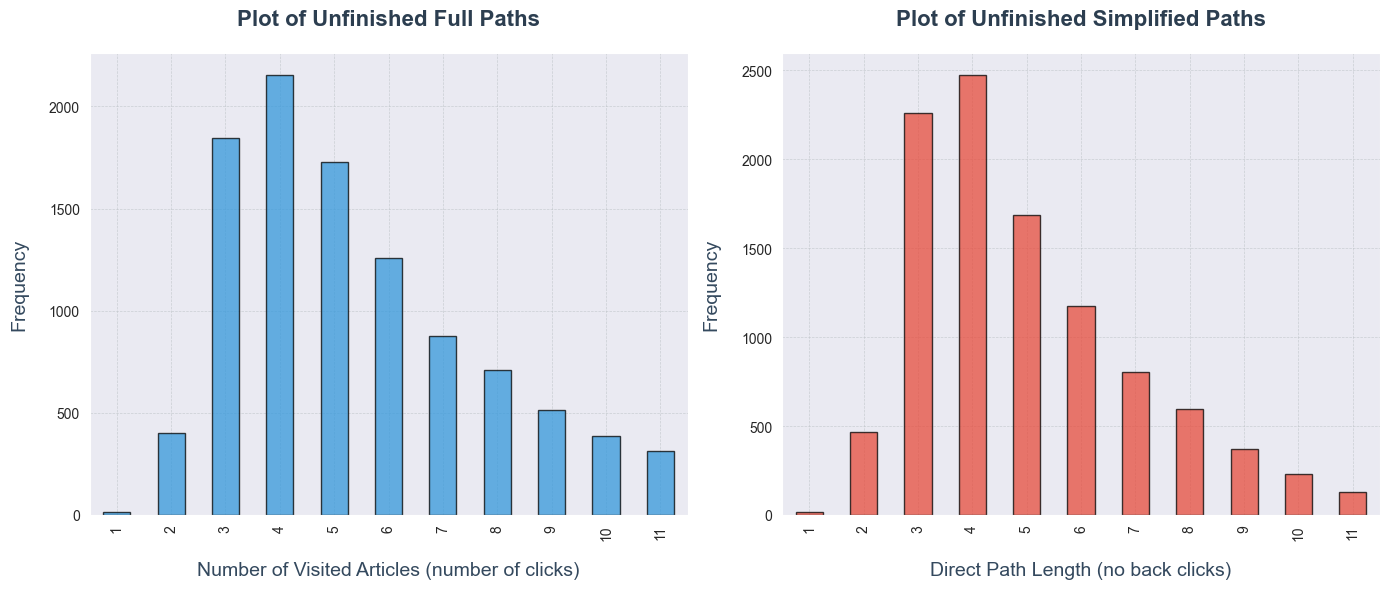

In [150]:
# Count occurrences of each path length
len_full_counts = filtered_unfinished_paths['full_path_length'].value_counts().sort_index()
len_simplified_counts = filtered_unfinished_paths['simplified_path_length'].value_counts().sort_index()

# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the bar plot for full path lengths on the first subplot
len_full_counts.plot(kind='bar', color='#3498db', edgecolor='black', alpha=0.75, ax=axes[0])
axes[0].set_title("Plot of Unfinished Full Paths", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
axes[0].set_xlabel("Number of Visited Articles (number of clicks)", fontsize=14, color='#34495E', labelpad=15)
axes[0].set_ylabel("Frequency", fontsize=14, color='#34495E', labelpad=15)
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')  # Subtle gridlines
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-ticks vertically

# Plot the bar plot for simplified path lengths on the second subplot
len_simplified_counts.plot(kind='bar', color='#e74c3c', edgecolor='black', alpha=0.75, ax=axes[1])
axes[1].set_title("Plot of Unfinished Simplified Paths", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
axes[1].set_xlabel("Direct Path Length (no back clicks)", fontsize=14, color='#34495E', labelpad=15)
axes[1].set_ylabel("Frequency", fontsize=14, color='#34495E', labelpad=15)
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')  # Subtle gridlines
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-ticks vertically

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

 Again the cut-off seems reasonable, maybe a bit low on the upper bound, but we will keep it like this for now.

In [151]:
# finally we merge the finished and unfinished data frames
filtered_paths = pd.concat([filtered_finished_paths, filtered_unfinished_paths]).drop('length_minus_distance', axis=1)

filtered_paths.to_feather('Data/dataframes/filtered_paths.feather')


For comparison let's also have a look at the distribution of the shortest possible distance distribution and its statistic. 

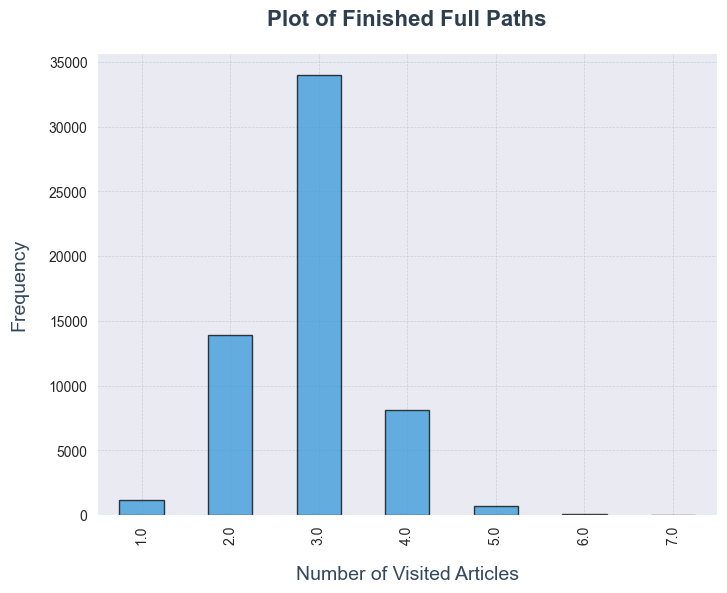

In [152]:
# Count occurrences of each distance
distance_counts = filtered_paths['distance'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 6))

# Bar plot with the same design as above
distance_counts.plot(kind='bar', color='#3498db', edgecolor='black', alpha=0.75, ax=ax)
ax.set_title("Plot of Finished Full Paths", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
ax.set_xlabel("Number of Visited Articles", fontsize=14, color='#34495E', labelpad=15)
ax.set_ylabel("Frequency", fontsize=14, color='#34495E', labelpad=15)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')  # Subtle gridlines
ax.tick_params(axis='x', rotation=90)  # Rotate x-ticks vertically

plt.show()

In [153]:
nan_count = filtered_paths['distance'].isna().sum()
print(f"There are {nan_count} NaN values in the 'distance' column.")

# look at some statistics

print("\nStatistics of 'distance' column:")
filtered_paths['distance'].describe()

There are 0 NaN values in the 'distance' column.

Statistics of 'distance' column:


count    57884.000000
mean         2.884683
std          0.710127
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          7.000000
Name: distance, dtype: float64

**Interesting observatin**

We just obversed that pretty much any article is reachable within at most 6 clicks (3 exeption with distance 7). This is interesting when we thik of the six degrees of separation idea...

### Start-Target article analysis

Now using the filtered path data we are interested in the distribution of the number of times the same start-target article pairs appear. Ideally this would be somewhat uniform.

In [154]:
start_target_groups = filtered_paths.groupby(['start_article', 'target_article'])
start_articles_groups = filtered_paths.groupby(['start_article'])
target_articles_groups = filtered_paths.groupby(['target_article'])


print(f"Start-Target pair group size statistics:\n    {start_target_groups.size().describe()}\n")
print(f"Sart article's group size statistics:\n    {start_articles_groups.size().describe()}\n")
print(f"Target article's group size statistics:\n    {target_articles_groups.size().describe()}\n")



Start-Target pair group size statistics:
    count    33674.000000
mean         1.718952
std         13.500968
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1308.000000
dtype: float64

Sart article's group size statistics:
    count    4157.000000
mean       13.924465
std        41.641078
min         1.000000
25%         7.000000
50%        10.000000
75%        16.000000
max      1357.000000
dtype: float64

Target article's group size statistics:
    count    3761.000000
mean       15.390588
std        45.002551
min         1.000000
25%         6.000000
50%        10.000000
75%        17.000000
max      1417.000000
dtype: float64



Clearly the distribution is not unfirom at all. Most games from a certain start article to target article were only attempted once but we also see that some are played over 1000 times! We can now try to find the most played paths and maybe already find out why they are played much more often.

In [155]:
# Group by 'start_article' and 'target_article' and aggregate
grouped = start_target_groups.agg(
    group_size=('target_article', 'size'),                      # Size of each group
    mean_full_path_length=('full_path_length', 'mean'),         # Mean of 'full_path_length'
    mean_simplified_path_length=('simplified_path_length', 'mean'),  # Mean of 'simplified_path_length'
    mean_rating=('rating', 'mean'),                             # Mean of 'rating' ignoring NaNs
    fraction_finished=('finished', 'mean')                    # fraction of 'finished' (mean of True/False)
).reset_index()

# Sort by group size in descending order and take the top 10 largest groups
top_groups = grouped.sort_values('group_size', ascending=False).head(10)

print("Top 10 largest groups by start_article and target_article pairs with some intesting metrics:\n", top_groups)

Top 10 largest groups by start_article and target_article pairs with some intesting metrics:
       start_article     target_article  group_size  mean_full_path_length  \
5169          Brain          Telephone        1308               5.075688   
2731       Asteroid             Viking        1284               5.497664   
30100       Theatre              Zebra        1201               5.517902   
24832       Pyramid               Bean        1075               5.362791   
3749         Batman               Wood         164               5.146341   
4475           Bird  Great_white_shark         142               4.260563   
3744         Batman      The_Holocaust         124               4.354839   
4092           Beer                Sun         121               4.008264   
4470           Bird       Adolf_Hitler         113               4.185841   
3712         Batman             Banana          80               5.687500   

       mean_simplified_path_length  mean_rating  fraction_

**Comment:** It appears that there is no abvious trend here. The most played start-target pairs are not the easiest which could have been the case due to players skipping the harder paths. This overrepresentation of some games is something we definetly need to take into consideration for further analysis!

## Analysis of the article data

In this section, we analyse key article attributes, including categories, hyperlinks and content characteristics. This will help us understand the distribution and variety within the data, providing a clearer picture of each article's features which will be useful later on.

In [156]:
print(f"In total there are {article_df.shape[0]} articles.")

In total there are 4604 articles.


### Most common categories of articles

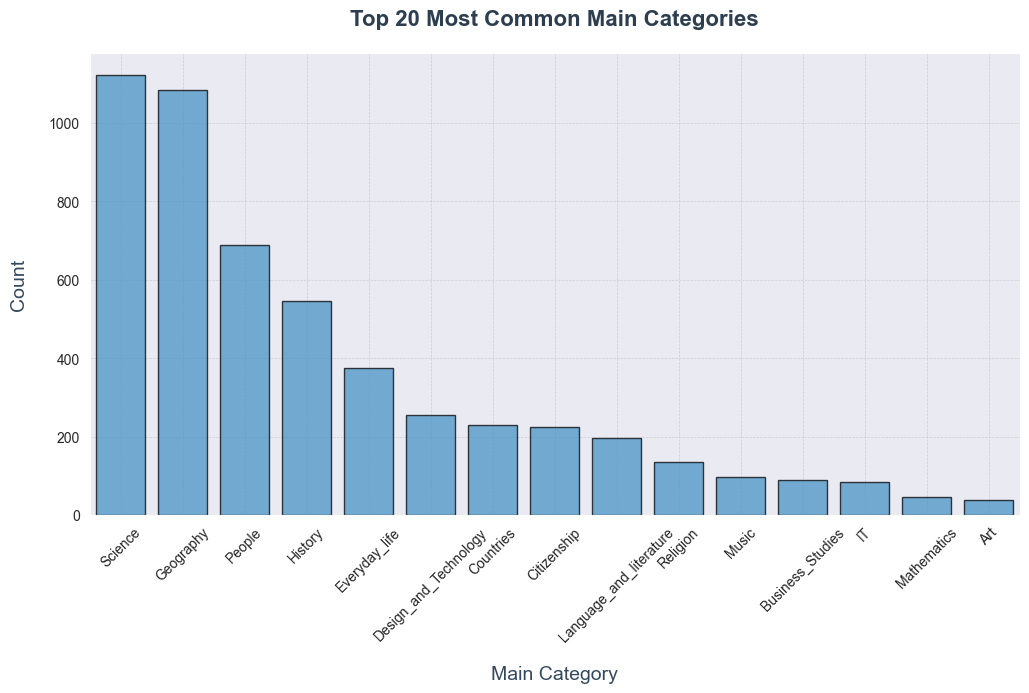

In [157]:
categories_exploded = article_df.explode('category')
categories_exploded['main_category'] = categories_exploded['category'].str.split('.').str[1]

# Here, we count the frequency of each main category
main_category_counts = categories_exploded['main_category'].value_counts()
top_20_main_categories = main_category_counts.head(20)


fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=top_20_main_categories.index, y=top_20_main_categories.values, ax=ax, color='#3498db', edgecolor='black', alpha=0.75)

ax.set_title("Top 20 Most Common Main Categories", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
ax.set_xlabel("Main Category", fontsize=14, color='#34495E', labelpad=15)
ax.set_ylabel("Count", fontsize=14, color='#34495E', labelpad=15)

ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')
ax.tick_params(axis='x', rotation=45)

plt.show()

**Comment:**  From the above bar plot, we can observe the distribution of different categories in our dataset. Geography and science are the two most prominent categories, with a large number of articles, while art and mathematics are represented by relatively fewer articles. For further analysis it might be interesting to see what categories are the most present in the best ranked articles.

### Incoming hyperlinks

Here, we focus on the attribute "incoming hyperlinks", which represents how easily an article can be reached from other articles in the network that have a one-way hyperlink to it.

First, we look at the 10 articles with the most incoming hyperlinks :

Top 10 Most Linked-To Articles:
linkTarget
United_States       1551
United_Kingdom       972
France               959
Europe               933
England              751
World_War_II         751
Germany              743
India                611
English_language     598
London               587
Name: count, dtype: int64


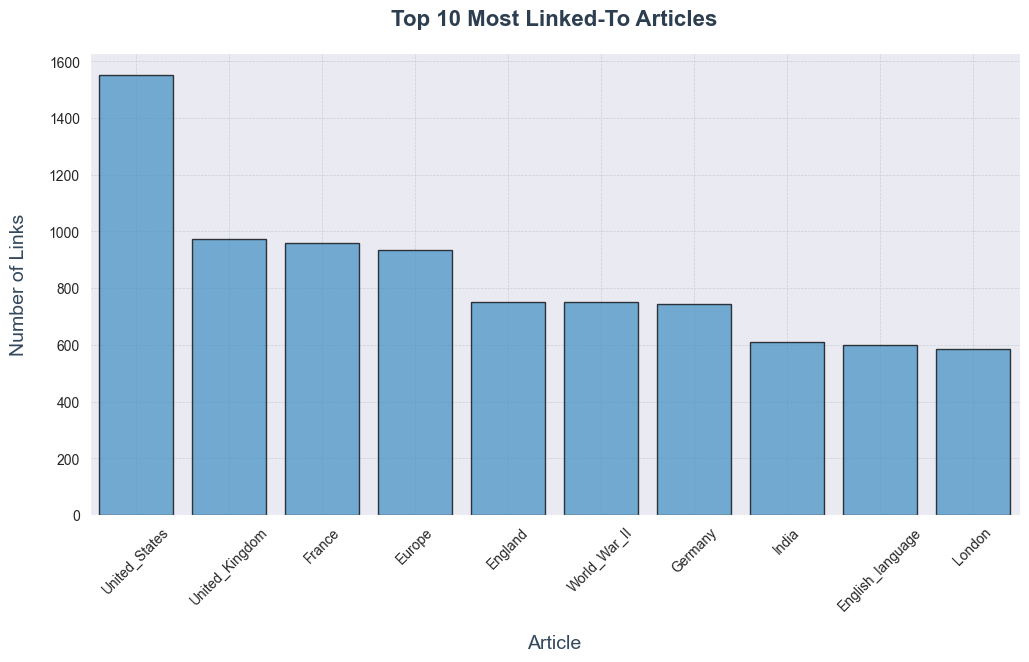

In [158]:
all_targets = article_df['linkTarget'].explode()

# Here, we count the occurrences of each target article
target_counts = all_targets.value_counts()

N = 10  
top_linked_articles = target_counts.head(N)

print(f"Top {N} Most Linked-To Articles:")
print(top_linked_articles)


fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=top_linked_articles.index, y=top_linked_articles.values, ax=ax, color='#3498db', edgecolor='black', alpha=0.75)

ax.set_title(f"Top {N} Most Linked-To Articles", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
ax.set_xlabel("Article", fontsize=14, color='#34495E', labelpad=15)
ax.set_ylabel("Number of Links", fontsize=14, color='#34495E', labelpad=15)

ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')
ax.tick_params(axis='x', rotation=45)

plt.show()

**Comment:** Here, we can observe that almost all of the top-linked articles are related to geography. This could be explained by, as seen previously, Geography is one of the most prevalent categories in our data. Also, geographical locations are often linked to a wide range of subjects which also likely contributes to the higher number of incoming hyperlinks for these articles. 

Now we can look at the distribution of the number of incoming hyperlinks :

Summary statistics for incoming links:
count    4135.000000
mean       28.992019
std        65.560574
min         1.000000
25%         4.000000
50%        10.000000
75%        29.000000
max      1551.000000
Name: count, dtype: float64


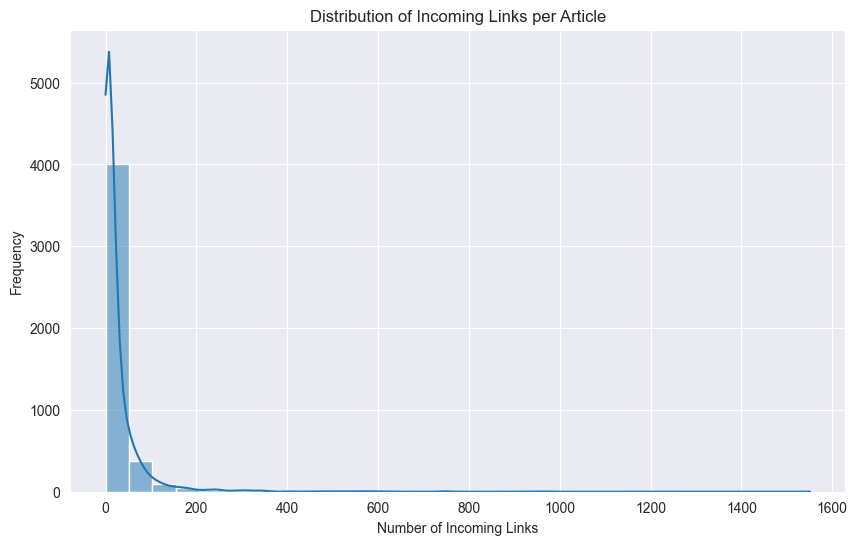

/Users/oscargoudet/.virtualenvs/ada-2024-project-adaholiks/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


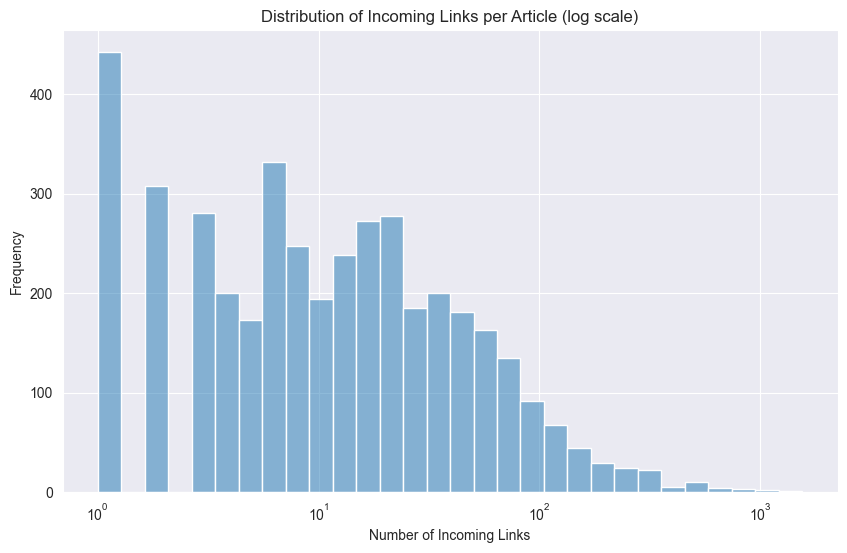

In [159]:
all_incoming_links = article_df['linkTarget'].explode()

incoming_link_counts = all_incoming_links.value_counts()

# Add the incoming link counts as a column in the DataFrame
# Initialize the column with 0 for all articles
article_df['incoming_links'] = article_df['article'].map(incoming_link_counts).fillna(0).astype(int)

print("Summary statistics for incoming links:")
print(incoming_link_counts.describe())

plt.figure(figsize=(10, 6))
sns.histplot(article_df['incoming_links'], bins=30, kde=True)
plt.title("Distribution of Incoming Links per Article")
plt.xlabel("Number of Incoming Links")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot the distribution of incoming links log scale for better visualization of the results
plt.figure(figsize=(10, 6))
sns.histplot(article_df['incoming_links'], bins=30, kde=True, log_scale=(True, False))
plt.title("Distribution of Incoming Links per Article (log scale)")
plt.xlabel("Number of Incoming Links")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


**Comment:** The distribution indicates that a small number of articles have a disproportionately large number of incoming links. compared to the rest of the network, these are the cenral hubs of the network ( e.g. United states article). With this heavy tail distribution we might think that it would be a good idea to filter out the outliers but in a systems like Wikispeedia (or any network), the heavy-tailed nature of link distributions is expected. Popular or highly connected articles likely play a central role in efficient navigation and removing any part of the distribution would skew our analysis and lead to biased results.



### Outgoing hyperlinks

Here, we focus on the attribute "outgoing hyperlinks", which represents how an article connects to other articles in the network through one-way hyperlinks.

First, we look at the 10 articles with the most outgoing hyperlinks :


Top 10 Articles with the Most Hyperlinks:
                                        article  num_hyperlinks
4297                              United_States             294
1247               Driving_on_the_left_or_right             255
2504                          List_of_countries             244
2503             List_of_circulating_currencies             236
2515                   List_of_sovereign_states             216
128                                      Africa             212
2505  List_of_countries_by_system_of_government             207
2433                                    Lebanon             192
2134                                   Interpol             191
340                                     Armenia             186


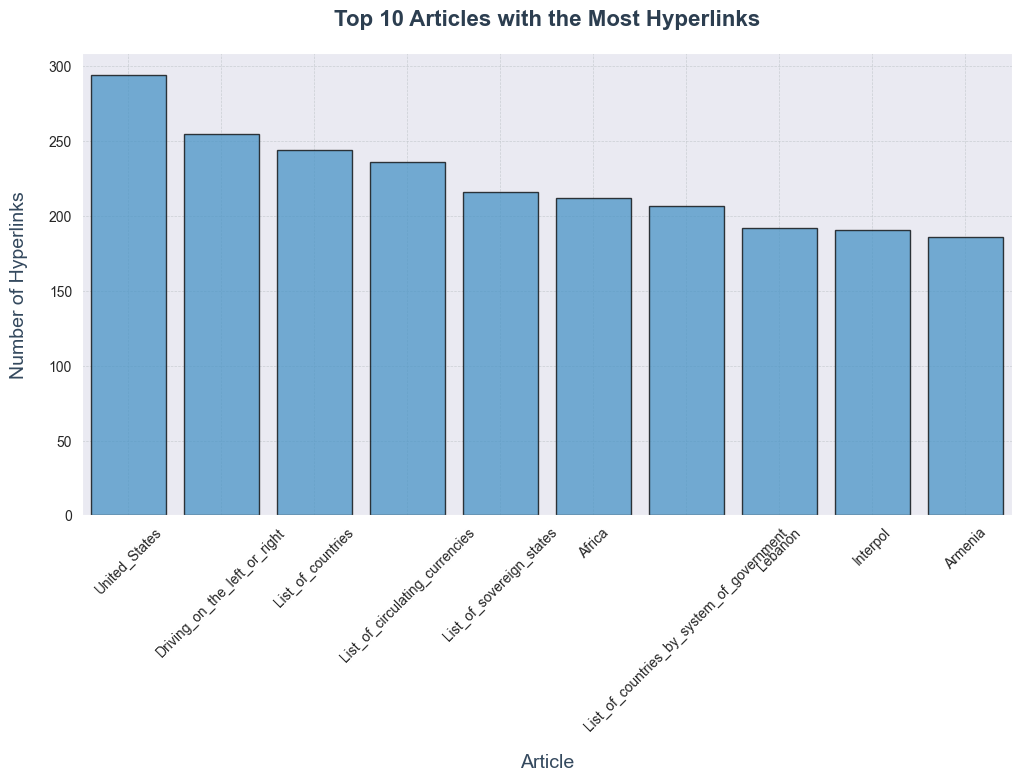

In [160]:
# Clean linkTarget column to replace the Nans by empty lists
article_df['linkTarget'] = article_df['linkTarget'].apply(
    lambda x: list(x) if isinstance(x, (list, np.ndarray)) else []
)

# Add a column with the number of hyperlinks in the article
article_df['num_hyperlinks'] = article_df['linkTarget'].apply(len)


top_hyperlinks = article_df.nlargest(10, 'num_hyperlinks')[['article', 'num_hyperlinks']]
print("\nTop 10 Articles with the Most Hyperlinks:")
print(top_hyperlinks)

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=top_hyperlinks['article'], y=top_hyperlinks['num_hyperlinks'], ax=ax, color='#3498db', edgecolor='black', alpha=0.75)

ax.set_title("Top 10 Articles with the Most Hyperlinks", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
ax.set_xlabel("Article", fontsize=14, color='#34495E', labelpad=15)
ax.set_ylabel("Number of Hyperlinks", fontsize=14, color='#34495E', labelpad=15)

ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')
ax.tick_params(axis='x', rotation=45)

plt.show()

**Comment:** It’s interesting to see that the "United States" article is the most important node in our network. This article consistently ranks highly across different measures. It often appears in the shortest paths between articles and is a common stop in players’ successful games. Because of this, it’s not surprising that it also has the highest number of both incoming and outgoing hyperlinks. We can also notice that some articles, like "List_of_countries," are mostly collections of hyperlinks. These types of articles act as hubs or directories with lots of outgoing hyperlinks, which is why they stand out when looking at hyperlink numbers. 

Now we can look at the distribution of the number of incoming hyperlinks :

Summary statistics for outgoing links:
count    4604.000000
mean       26.038662
std        24.201491
min         0.000000
25%        11.000000
50%        19.000000
75%        33.000000
max       294.000000
Name: num_hyperlinks, dtype: float64


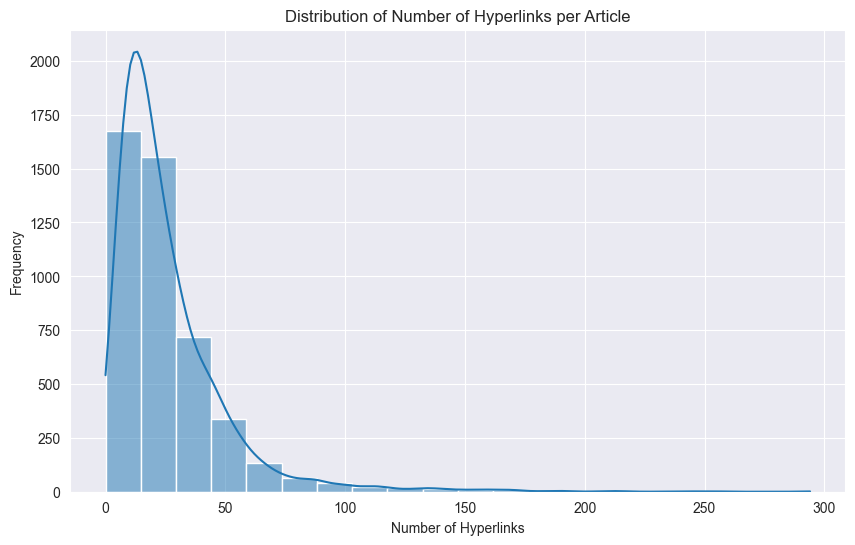

/Users/oscargoudet/.virtualenvs/ada-2024-project-adaholiks/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


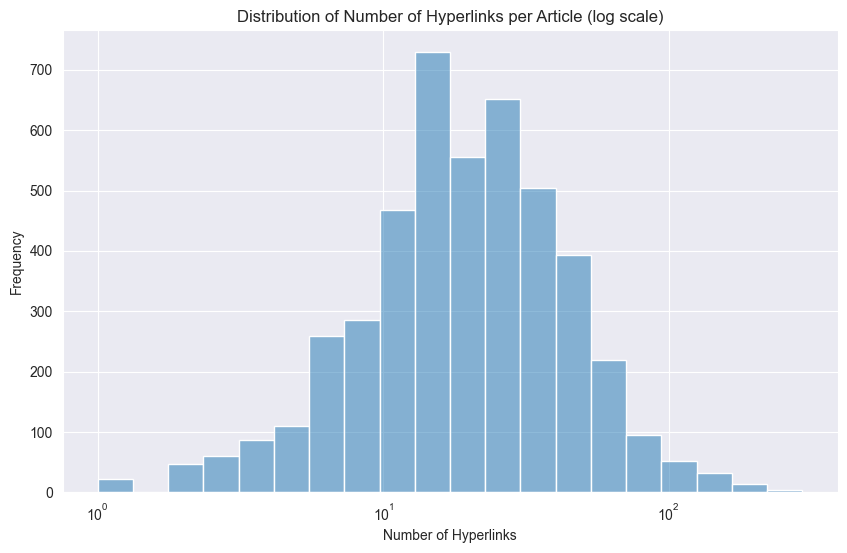

In [161]:
print("Summary statistics for outgoing links:")
print(article_df['num_hyperlinks'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(article_df['num_hyperlinks'], bins=20, kde=True)
plt.title("Distribution of Number of Hyperlinks per Article")
plt.xlabel("Number of Hyperlinks")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot the distribution of the number of hyperlinks log scale for better visualisation
plt.figure(figsize=(10, 6))
sns.histplot(article_df['num_hyperlinks'], bins=20, kde=True, log_scale=(True, False) )
plt.title("Distribution of Number of Hyperlinks per Article (log scale)")
plt.xlabel("Number of Hyperlinks")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

**Comment:** The summary statistics and the above distribution reveal that the number of outgoing links varies widely across articles. Most articles have between 11 and 33 outgoing links. However, the mean of 26 and the standard deviation (24.2) indicate that some articles have significantly more links, as highlighted by the maximum of 294, again highlighting disproportionnality of number of links per article. 

### Hyperlink density

Here, we now focus on the attribute "hyperlink density", which combines the length of an article with the number of outgoing hyperlinks it pocesses.

First, we look at the 10 articles with the highest hyperlink density :


Top 10 Articles by Hyperlink Density:
                                                article  hyperlink_density
2493                         List_of_European_countries           0.025199
2488                          List_of_African_countries           0.024315
2490                            List_of_Asian_countries           0.023562
2496                         List_of_Oceanian_countries           0.022334
2495                   List_of_North_American_countries           0.019239
2134                                           Interpol           0.017781
3020                                   Northwest_Africa           0.017121
2505          List_of_countries_by_system_of_government           0.016477
2509  List_of_members_of_the_Commonwealth_of_Nations...           0.013772
2503                     List_of_circulating_currencies           0.012900


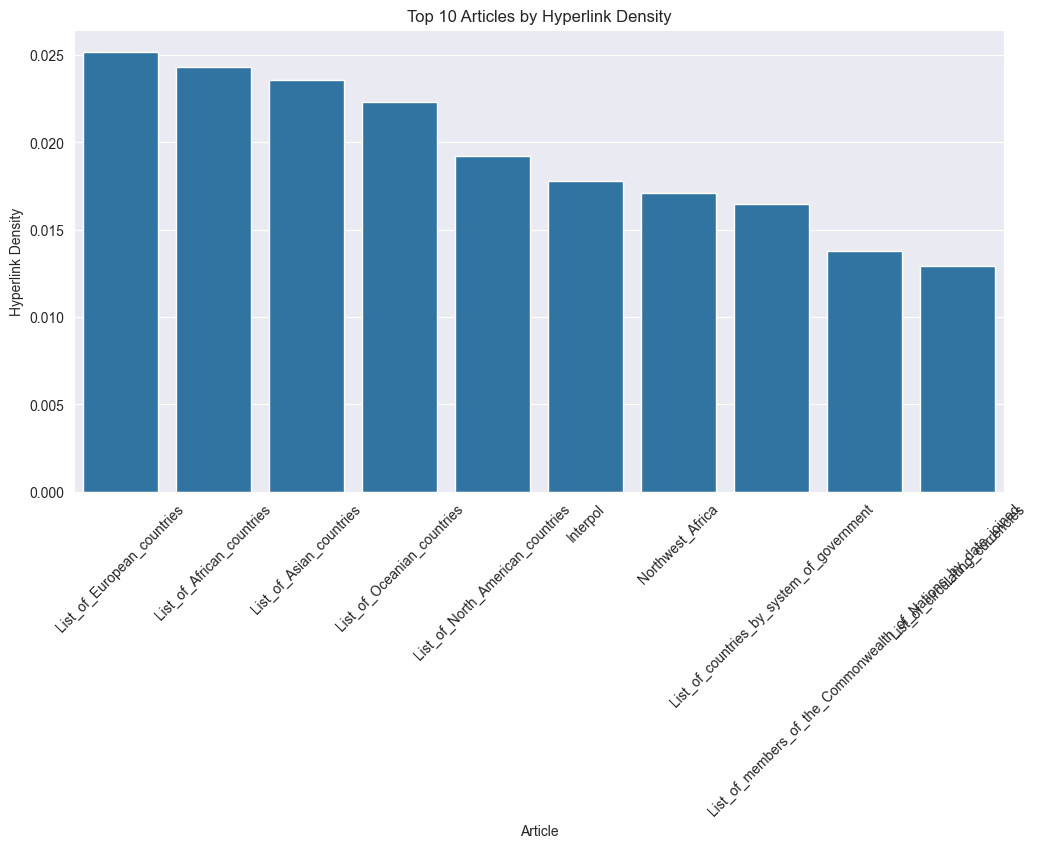

In [162]:
# Ensure plain_text is a string and handle missing values
article_df['plain_text'] = article_df['plain_text'].fillna("").astype(str)

# Calculate the number of characters in the plain_text column
article_df['num_characters'] = article_df['plain_text'].apply(len)

# Calculate hyperlink density (num_hyperlinks / num_characters)
# Avoid division by zero by setting density to 0 if num_characters is 0
article_df['hyperlink_density'] = article_df.apply(
    lambda row: row['num_hyperlinks'] / row['num_characters'] if row['num_characters'] > 0 else 0,
    axis=1
)

# Identify articles with the highest hyperlink density
top_hyperlink_density = article_df.sort_values(by='hyperlink_density', ascending=False).head(10)
print("\nTop 10 Articles by Hyperlink Density:")
print(top_hyperlink_density[['article', 'hyperlink_density']])


plt.figure(figsize=(12, 6))
sns.barplot(x=top_hyperlink_density['article'], y=top_hyperlink_density['hyperlink_density'])
plt.xticks(rotation=45)
plt.title("Top 10 Articles by Hyperlink Density")
plt.xlabel("Article")
plt.ylabel("Hyperlink Density")
plt.show()

**Comment:** We can see that all the articles with the highest hyperlink density are "List" articles. This makes sense, as these articles contain very little text, and nearly every item in the list is a hyperlink to another article. However, this suggests that hyperlink density might not be a reliable indicator of an article’s quality for efficient navigation.


Now we can look at the distribution of hyperlink density :

Summary statistics for hyperlink density:
count    4604.000000
mean        0.001604
std         0.001573
min         0.000000
25%         0.000727
50%         0.001208
75%         0.001953
max         0.025199
Name: hyperlink_density, dtype: float64


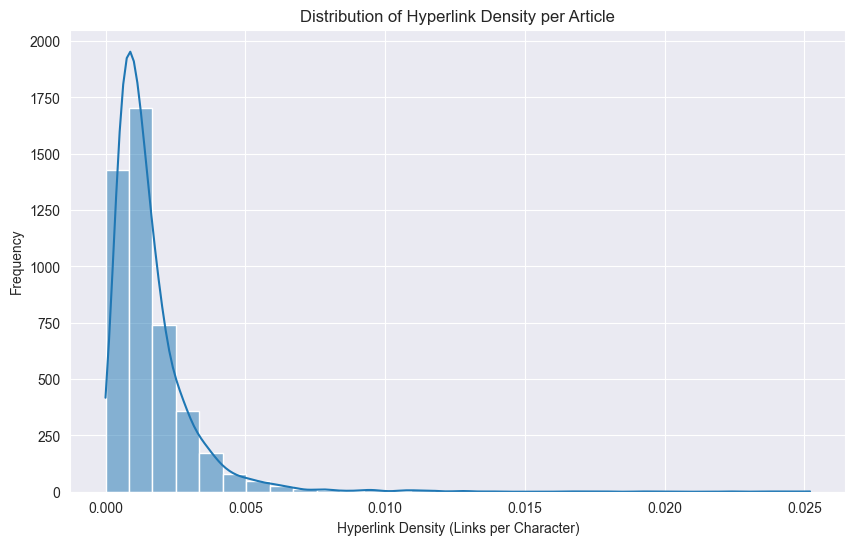

/Users/oscargoudet/.virtualenvs/ada-2024-project-adaholiks/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


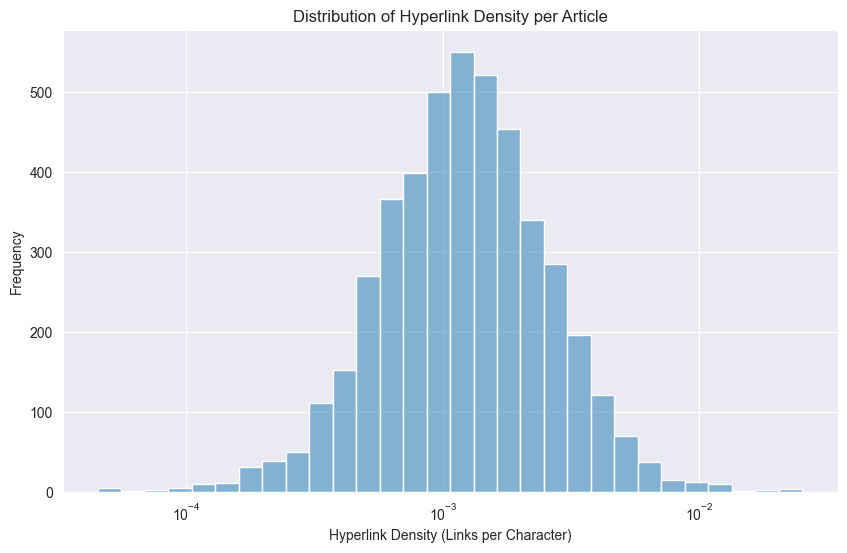

In [163]:
# Summary statistics of hyperlink density
print("Summary statistics for hyperlink density:")
print(article_df['hyperlink_density'].describe())

# Plot the distribution of hyperlink density
plt.figure(figsize=(10, 6))
sns.histplot(article_df['hyperlink_density'], bins=30, kde=True)
plt.title("Distribution of Hyperlink Density per Article")
plt.xlabel("Hyperlink Density (Links per Character)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot the distribution of hyperlink density log scale
plt.figure(figsize=(10, 6))
sns.histplot(article_df['hyperlink_density'], bins=30, kde=True, log_scale=(True, False) )
plt.title("Distribution of Hyperlink Density per Article")
plt.xlabel("Hyperlink Density (Links per Character)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

**Comment:** Here we can see the hyperlink density in the graph follows again a log normal distribution which could again be expected in a network

### Number of characters

Finally, we focus on the attribute "number of characters", which is an indication of the length of each article.


Top 10 Articles by Number of Characters:
                 article  num_characters
734     Byzantine_Empire          108718
4542        World_War_II          101666
4066       The_Holocaust          100238
1453       Extinct_birds           94934
2108  Indo-Greek_Kingdom           91676
2445        Leon_Trotsky           91306
4363         Vietnam_War           90550
1821               Guqin           87886
1369       Elvis_Presley           87815
1012    Condoleezza_Rice           85726


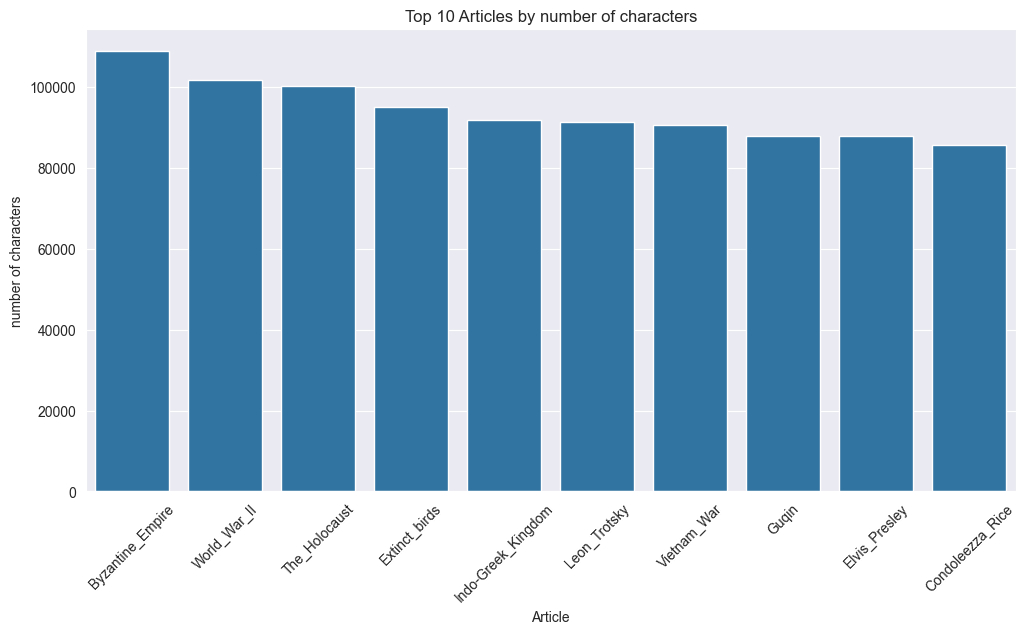

In [164]:
top_characters = article_df.sort_values(by='num_characters', ascending=False).head(10)
print("\nTop 10 Articles by Number of Characters:")
print(top_characters[['article', 'num_characters']])

plt.figure(figsize=(12, 6))
sns.barplot(x=top_characters['article'], y=top_characters['num_characters'])
plt.xticks(rotation=45)
plt.title("Top 10 Articles by number of characters")
plt.xlabel("Article")
plt.ylabel("number of characters")
plt.show()

**Comment:** The top 10 articles with the highest letter count are dominated by historical events, likely because these events are long, well-documented, and contain a lot of information. In addition to historical events, three of the articles are biographical, indicating that articles about people can also have a high letter count which could be due to the detailed nature of their life histories leading to long articles.


Summary statistics for number of characters:
count      4604.000000
mean      21232.968723
std       15508.639317
min         828.000000
25%        8811.750000
50%       17736.500000
75%       30104.750000
max      108718.000000
Name: num_characters, dtype: float64


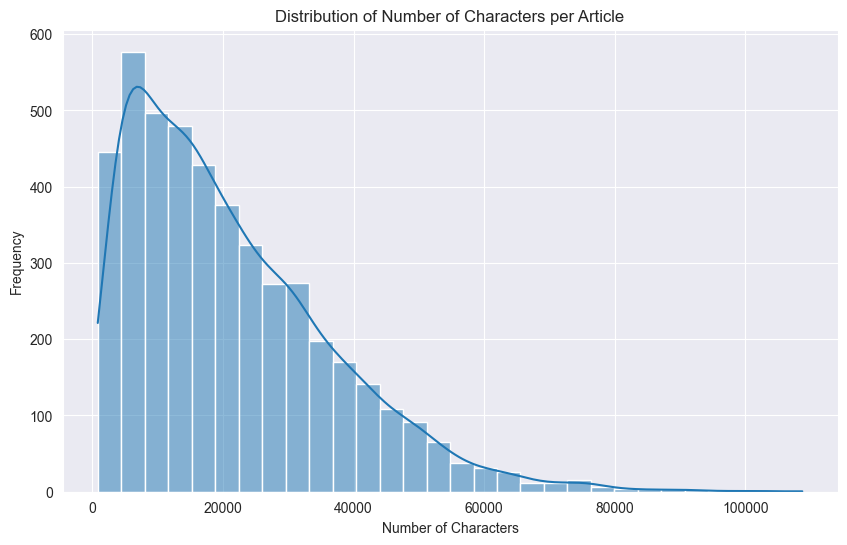

In [165]:
print("\nSummary statistics for number of characters:")
print(article_df['num_characters'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(article_df['num_characters'], bins=30, kde=True)
plt.title("Distribution of Number of Characters per Article")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

**Comment:** Most articles range between 8'000 and 30'000 characters, with a slight right skew due to a few very long articles, indicating considerable variation in article lengths.

In [166]:
article_df.to_feather('Data/dataframes/article_df_features.feather')

## Exploration of semantic distances between articles

### Semantic Similarity

We can compute basic semantic distance on articles simply by creating embeddings for the titles of the articles. In P3, we can expand this to calculate embeddings using full article text. 

### Computing the Embeddings

First, let's compute the embeddings. We can follow a HuggingFace tutorial on generating text embeddings. This tutorial is found [here](https://huggingface.co/blog/getting-started-with-embeddings). For each title, we will generate an embedding, and store it in our dataframe.

In [167]:
article_names = articles['article']

# Here fetch a token from hugging face website
# https://huggingface.co/blog/getting-started-with-embeddings
model_id = "sentence-transformers/all-MiniLM-L6-v2"
hf_token = "insert token here"

api_url = f"https://api-inference.huggingface.co/pipeline/feature-extraction/{model_id}"
headers = {"Authorization": f"Bearer {hf_token}"}

In [168]:
def query(texts):
    response = requests.post(api_url, headers=headers, json={"inputs": texts, "options":{"wait_for_model":True}})
    return response.json()

article_names_list = article_names.tolist()

#replace _ with space in article names
article_names_list = [name.replace("_", " ") for name in article_names_list]

output = query(article_names_list)

articles['embeddings'] = output

articles.to_feather('Data/dataframes/article_dataframe_with_embeddings.feather')

### Analyzing the Embeddings

There are lots of tools to visualize and analyze embeddings. In order to extract meaningful representations, a common tactic is to reduce the dimensionality of the embeddings. The two main tools for this are PCA and T-SNE. 
See [here](https://distill.pub/2016/misread-tsne/) for a great overview on T-SNE.
We can use both of these via scikit-learn. For now, we just want to get a feel for the data. Let's use tensorflow's Embedding Projector tool. This tool can be hosted locally or used in a browser. 

#### Embedding Projector

Embedding Projector is a useful tool made by TF to look at word embedding spaces. Let's save our data so it can be opened there.

https://projector.tensorflow.org/

Note that the embedding projector can also be used locally.

In [169]:
# Here uncomment the code oônce a token is used to see our results

# Separate embeddings as a new DataFrame
#embeddings_df = pd.DataFrame(articles['embeddings'].tolist())

# Save embeddings to TSV
#embeddings_df.to_csv('Data/embeddings/embeddings.tsv', sep='\t', header=False, index=False)

# Save metadata to TSV
#metadata_df = articles[['article']]
#metadata_df.to_csv('metadata.tsv', sep='\t', header=False, index=False)

#articles[articles['article'] == 'Code_of_Hammurabi']

In [170]:
# Taken from OpenAI's tutorial on embeddings

#matrix = np.array(articles['embeddings'].tolist())

# Create a t-SNE model and transform the data
#tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
#vis_dims = tsne.fit_transform(matrix)

#colors = ["red", "darkorange", "gold", "turquiose", "darkgreen"]
#x = [x for x,y in vis_dims]
#y = [y for x,y in vis_dims]
# color_indices = df.Score.values - 1

#colormap = matplotlib.colors.ListedColormap(colors)
#plt.scatter(x, y, cmap=colormap, alpha=0.3)
#plt.title("Article Names visualized using t-SNE")

### TF's Embedding Projector

After saving our embeddings and their required metadata according to EmbeddingProjector's specifications, we can load the data into the tool. For now, let's use T-SNE in order to group the data. Here is what the data looks like after 1000 iterations of T-SNE:

![Default projections](Figures/default_1000_tsne.png)

But . . . does it even work? Well, let's do a gut check. What is that clump of titles at the top?

![Tropical Storms](Figures/tropical_storms.png)

Interesting! It seems like tropical storms are on a level of their own! That is, they share semantic meaning with each other but not other titles.Let's look at some common according to our statistics. For example, what is close to the United States?

![US TSNE](Figures/UnitedStates_TSNE.png)

We can also see what is close to the `United_States` title in the original, unprojected space. Cosine and Euclidean distance are both easily implementable in python, and already exist in multiple packages like scikit-learn.

![US Nearest](Figures/US_Nearest.png)

This Euclidean/Cosine distance will serve as our metric for semantic distance.

**END OF PREPROCESSING & exploratory data analysis**

# Part 2 : graph theory based top articles

**Comment:** In this analysis, we have divided the count by the total number of shortest paths for each source-target pair. This normalization helps us measure the true importance of each article in the network. Without normalization, an article that appears in every shortest path for a specific source-target pair might seem highly important, even if it doesn’t play a critical role across the entire network. By normalizing, we avoid overemphasizing articles that are only crucial within specific source-target pairs and ensure that the count more accurately reflects an article’s overall significance in the network.

$$
\text{Article k's Importance in (i ; j)} = \frac{A_{k}^{(i,j)}}{P^{(i,j)}}
$$

where:

$$
\begin{aligned}
A_{k}^{(i,j)} &= \text{Number of times article } k \text{ appears in shortest paths between source } i \text{ and target } j, \\
P^{(i,j)} &= \text{Total number of shortest paths between } i \text{ and } j.
\end{aligned}
$$



In [171]:

paths_finished['finished'] = True
paths_finished['failure_reason'] = None

paths_finished['start_article'] = paths_finished['path'].apply(lambda x: x.split(';')[0])
paths_finished['target_article'] = paths_finished['path'].apply(lambda x: x.split(';')[-1])


paths_unfinished['finished'] = False

paths_unfinished.rename(columns={'type': 'failure_reason', 'target' : 'target_article'}, inplace=True)

paths_unfinished['start_article'] = paths_unfinished['path'].apply(lambda x: x.split(';')[0])

paths = pd.concat([paths_finished, paths_unfinished])

finished_paths = paths[paths['finished'] == True]

unique_pairs = finished_paths[['start_article', 'target_article']].drop_duplicates()

pair_counts = finished_paths.groupby(['start_article', 'target_article']).size().reset_index(name='count')

#pair_counts

**Comment:** We also decided to concentrate our analysis on source-target pairs that are actually used in the game. By focusing only on these pairs, we generate a final list of articles that are theoretically advantageous for all possible gameplay scenarios. This approach prevents the inclusion of articles that may appear to be effective in connecting pairs not relevant to the game, which could otherwise skew the analysis.

In [172]:
from collections import defaultdict

node_counts = defaultdict(int)

errors = 0

all_nb_of_shortest_paths = []

for _, row in pair_counts.iterrows():
    source = row['start_article']
    target = row['target_article']

    try:

        all_paths = list(nx.all_shortest_paths(G, source=source, target=target))

        nb_of_shortest_paths = len(all_paths)

        all_nb_of_shortest_paths.append(nb_of_shortest_paths)
        
        for path in all_paths:
            for node in path:
                if node != source and node != target:
                    node_counts[node] += 1/nb_of_shortest_paths

    except nx.NetworkXNoPath:
        # Skip this source-target pair if no path exists
        errors +=1


node_counts_df = pd.DataFrame(node_counts.items(), columns=['Node', 'ShortestPathCount'])

### Results

In [173]:
# Sort by the 'ShortestPathCount' column in ascending order
node_counts_df = node_counts_df.sort_values(by='ShortestPathCount', ascending=False)
node_counts_df.head(20)

,Node,ShortestPathCount
27,United_States,2778.997827
124,United_Kingdom,1128.250118
77,Europe,809.943234
79,England,746.721314
174,Africa,716.774062
2,Germany,614.765519
92,World_War_II,534.374375
230,Japan,526.817727
143,Earth,480.186276
1,France,417.042087


**Comment:** Here, we display the first 20 articles identified as most important across the network. These articles are ranked based on their normalized shortest path count, highlighting those that play a critical role in connecting various parts of the network. We can notice that topics related to influential countries (like the United States and the United Kingdom), broad regions (such as Europe and Africa), and significant historical events (like World War II) are among the highest-ranked. This suggests that geopolitical, regional, and historical themes are central to the network's structure, serving as key connectors across diverse topics.

In [174]:
node_counts_df['ShortestPathCount'].describe()

count    3735.000000
mean       13.928782
std        63.764178
min         0.003125
25%         0.506233
50%         2.513890
75%         9.294983
max      2778.997827
Name: ShortestPathCount, dtype: float64

**Comment:** 
- *Count :* Here, we see that 3'735 out of 4'604 articles are active nodes in the games network, representing about 81% of the total. This suggests that the majority of articles contribute to the games network's connectivity, while the remaining 19% may be more isolated or peripheral.
- *Mean :* The mean suggests most articles are not very important based on our metric. The quantiles support this, with the 25th and 50th percentiles showing that most articles appear in only a few shortest paths. A small number of articles are highly central, indicating a long-tailed distribution where a few nodes dominate the network.

## Part 3 : game based top articles

We will try to quantify what articles are the most important in user navigation using various approaches from simple to more complex
### Naive approach

First we just look at articles than come up the most in the filtered data. This is of course a very naive approach and will just serve as comparison for the subsequent ones.

In [175]:
# 1. naive approach described above.
# will use the simplied paths (direct paths) as contrary to full path more apperances necessary imply importance

simplified_paths = filtered_paths['simplified_path'].copy()

simplified_paths.apply(lambda l: l[1:-1]) # drop start and target article

article_count = pd.Series(dtype=int)

# Loop through each path and count each article
for path in simplified_paths:
    for article in path:
        article_count[article] = article_count.get(article, 0) + 1

# order 
article_count = article_count.sort_values(ascending=False)

article_count.head(10)

United_States     9745
Europe            4581
United_Kingdom    4148
England           3495
Earth             3418
Africa            2976
World_War_II      2382
North_America     1960
Germany           1793
Human             1727
dtype: int64

### Weighted Average of All Articles

This allows for averaging without being overly influenced by differences between the start and target pairs. We will define weight as: 
$$
\text{Weight} = 1 - \frac{\text{Actual Path Length} - \text{Optimal Distance}}{\text{Actual Path Length}} = \frac{\text{Optimal Path Length}}{\text{Actual Path Length}}
$$
This weight captures how much the actual path deviates from the optimal distance as a ratio of the actual path length.

The weighted average will allow us to evaluate the average quality of an article's appearances.

Note: I don't consider the start and target articles, in the paths, maybe keep targets ?

In [176]:
# we can only use finished paths for this analysis.
# use simplified path lengths for diff calculation

# 1. make new df where a weight is assigned to each path (both described above), and a col for simplified and full path
# 2. A function that takes this df and iterates through the simplified path column, where it checks what articles appear in it
#    and adds that weight that row to a total weight sum of an other data frame. This other data frame should consist of the following rows:
#    |article_name|n_counts|weighted_avg|normalized_path_score_avg|

# 1.
df = filtered_finished_paths[['simplified_path', 'simplified_path_length', 'distance']].copy()

# again drop start and end articles
df['simplified_path'] = df['simplified_path'].apply(lambda l: l[1:-1])

# Calc weight and add to df
df['weight'] = df['distance'] / df['simplified_path_length']

df.head()


,simplified_path,simplified_path_length,distance,weight
0,"[15th_century, 16th_century, Pacific_Ocean, At...",8,3.0,0.375000
1,"[Europe, Africa, Atlantic_slave_trade]",4,3.0,0.750000
2,"[Niger, Nigeria, British_Empire, Slavery, Afri...",7,3.0,0.428571
3,"[Renaissance, Ancient_Greece]",3,2.0,0.666667
4,"[Italy, Roman_Catholic_Church, HIV, Ronald_Rea...",6,3.0,0.500000


In [177]:
# 2. Create an empty DataFrame for aggregating article results 
avg_article_weight_df = pd.DataFrame(columns=['article', 'n_appearances', 'weighted_avg'])
avg_article_weight_df.set_index('article', inplace=True)

for index, row in df.iterrows():
    weight = row['weight']
    simplified_path = row['simplified_path']

    if len(simplified_path) > 2:
        # Iterate through articles in the simplified path
        for article in simplified_path[1:-1]: # don't consider start and target articles
            if article not in avg_article_weight_df.index:
                # If the article is not in the DataFrame, initialize a new row
                avg_article_weight_df.loc[article] = [0, 0]

            # Update counts and weighted sums
            avg_article_weight_df.at[article, 'n_appearances'] += 1
            avg_article_weight_df.at[article, 'weighted_avg'] += weight

# Calculate the weighted average by dividing by the counts
avg_article_weight_df['weighted_avg'] = avg_article_weight_df['weighted_avg'] / avg_article_weight_df['n_appearances']

/var/folders/80/hqwr4qh5045_gwp_l1039pdw0000gn/T/ipykernel_20752/1704071625.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  avg_article_weight_df.at[article, 'weighted_avg'] += weight


In [178]:
avg_article_weight_df = avg_article_weight_df.sort_values(by='weighted_avg', ascending=False)
avg_article_weight_df

,n_appearances,weighted_avg
article,,
Zheng_He,1,1.00
International_Red_Cross_and_Red_Crescent_Movement,1,1.00
Badminton,1,1.00
H5N1,1,1.00
Antimony,1,1.00
...,...,...
Gallium,1,0.25
Akkadian_Empire,1,0.25
Wild_cat,1,0.25


Articles that only show up once in the whole paths considered are not assigned a meaningfull weight value. We need to filter again. Whe can for example only consider articles that at least appear 30 times. This would still leave us with a fairly large data set that we can use for further analysis.

In [179]:
filtered_weighted_avg_df = avg_article_weight_df[avg_article_weight_df['n_appearances'] >= 30]
filtered_weighted_avg_df

,n_appearances,weighted_avg
article,,
Extrasolar_planet,48,0.727364
Black_Sea,53,0.666584
Whale_shark,272,0.651068
Information,321,0.649007
International_law,31,0.643510
...,...,...
Bible,46,0.449474
Radio,85,0.449402
Athens,66,0.448088


### Weighted Sum of sampled articles

In this case, instead of taking the average of the weight per article we sum the wieghts over all articles. This metric will of course be larger for articles that appear more often. Thus, it will be less informative about article quality, but likely more meaningfull in showing what articles are the most usefull for players overall. 
To adjust for the imbalance in start-target pairs, we need to downsample the data to only 1 sample per pair. As we saw that over 50% of the data only has one such sample already, this should not result in a to large chunck of removed samples.

In [180]:
# first downsample the df so that there only is one sample per start-target pair.

# Set the random seed for reproducibility
np.random.seed(42)

shuffled_df = filtered_finished_paths.sample(frac=1).reset_index(drop=True)
filtered_paths_sampled = shuffled_df.drop_duplicates(subset='identifier', keep='first').reset_index(drop=True)

# Calculate the number of removed rows
removed = filtered_finished_paths.shape[0] - filtered_paths_sampled.shape[0]

# Print the result
print(f"In sampling a total of {removed} samples were removed, "
      f"which represents {removed / filtered_finished_paths.shape[0] * 100:.3f}% of the original data.",
      f"{filtered_paths_sampled.shape[0]} samples remain.")

In sampling a total of 20010 samples were removed, which represents 41.965% of the original data. 27673 samples remain.


In [181]:
# very similar code as for weighted average overall
df2 = filtered_paths_sampled[['simplified_path', 'simplified_path_length', 'distance']].copy()

# Calc weight and add to df
df2['weight'] = df2['distance'] / df2['simplified_path_length']

article_weightes_sum_df = pd.DataFrame(columns=['article', 'n_appearances', 'weighted_sum'])
article_weightes_sum_df.set_index('article', inplace=True)

for index, row in df2.iterrows():
    weight = row['weight']
    simplified_path = row['simplified_path']

    if len(simplified_path) > 2:
        # Iterate through articles in the simplified path
        for article in simplified_path[1:-1]: # don't consider start and target articles
            if article not in article_weightes_sum_df.index:
                # If the article is not in the DataFrame, initialize a new row
                article_weightes_sum_df.loc[article] = [0, 0]

            # Update counts and weighted sums
            article_weightes_sum_df.at[article, 'n_appearances'] += 1
            article_weightes_sum_df.at[article, 'weighted_sum'] += weight

/var/folders/80/hqwr4qh5045_gwp_l1039pdw0000gn/T/ipykernel_20752/1887511229.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  article_weightes_sum_df.at[article, 'weighted_sum'] += weight


In [182]:
article_weightes_sum_df = article_weightes_sum_df.sort_values(by='weighted_sum', ascending=False)

article_weightes_sum_df.head(10)

,n_appearances,weighted_sum
article,,
United_States,4534,3205.278499
Europe,2168,1423.762302
United_Kingdom,2113,1401.557143
England,1660,1083.717027
Africa,1364,930.151768
Earth,1187,763.651587
World_War_II,1104,757.799206
France,837,557.654762
Germany,811,556.206349


**Comment** 

This is not really a surprise, the articles that show up the most often also have the highest weighted_sum. Does that necessarily make them the best articles for efficient users to navigation? This is hard to tell as they are obviously different from highest 'quality' articles we extracted above.


Alternatively, we can center the weights around 0 before computing the weighted sum to reduce the bias introduced by the number of appearances of articles. This way, articles with more appearances won't necessarily lead to a disproportionately large weighted sum score. This can help highlight articles that are truly impactful relative to the average. 
To do so we use the follwoing formulas:

$$
\text{article\_mean\_weight} = \frac{\sum (\text{weight} \times \text{simplified\_path\_length})}{\sum (\text{simplified\_path\_length})}
$$

$$
\text{centered\_weight} = \text{weight} - \text{article\_mean\_weight}
$$

$$
\text{article\_weighted\_sum} = \sum \left( \text{centered\_weight} \times \text{n\_appearances} \right)
$$

In [183]:
# Calculate mean weight
article_mean_weight = (df2['weight'] * df2['simplified_path_length']).sum() / df2['simplified_path_length'].sum()

# Center the weights by subtracting the mean
df2['centered_weight'] = df2['weight'] - article_mean_weight

article_weightes_sum_df2 = pd.DataFrame(columns=['article_name', 'n_appearances', 'weighted_sum'])
article_weightes_sum_df2.set_index('article_name', inplace=True)

for index, row in df2.iterrows():
    centered_weight = row['centered_weight']
    simplified_path = row['simplified_path']

    if len(simplified_path) > 2:
        for article in simplified_path[1:-1]: # don't consider start and target articles
            if article not in article_weightes_sum_df2.index:
                article_weightes_sum_df2.loc[article] = [0, 0]  # Initialize count and sum

            # Update counts and centered weighted sum
            article_weightes_sum_df2.at[article, 'n_appearances'] += 1
            article_weightes_sum_df2.at[article, 'weighted_sum'] += centered_weight


/var/folders/80/hqwr4qh5045_gwp_l1039pdw0000gn/T/ipykernel_20752/1393077498.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09830571274589062' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  article_weightes_sum_df2.at[article, 'weighted_sum'] += centered_weight


In [184]:
article_weightes_sum_df2 = article_weightes_sum_df2.sort_values(by='weighted_sum', ascending=False)

article_weightes_sum_df2


,n_appearances,weighted_sum
article_name,,
United_States,4534,250.496601
Africa,1364,41.240760
World_War_II,1104,38.328713
Japan,484,28.509294
Germany,811,27.682282
...,...,...
Great_Britain,297,-23.702013
European_Union,431,-24.659206
Continent,305,-28.221520


Things have definetly changed let's compare the top scoring articles of the centered weighted sum vs weighted sum and the average weighted average.

In [185]:
# Again the articles that appear only few times should not be considered
article_weightes_sum_df2 = article_weightes_sum_df2[article_weightes_sum_df2['n_appearances'] >= 30]
article_weightes_sum_df2

,n_appearances,weighted_sum
article_name,,
United_States,4534,250.496601
Africa,1364,41.240760
World_War_II,1104,38.328713
Japan,484,28.509294
Germany,811,27.682282
...,...,...
Great_Britain,297,-23.702013
European_Union,431,-24.659206
Continent,305,-28.221520


**Comment**

It is obvious that in this apporach articles that appear much more often will also have the most extreme weight values. But this might be a decent compromise between article 'quality' and article 'usefulness' for players.

**Comparison** of the methods

In [186]:
top_n = 10

# Top articles
print(f"Top {top_n} articles for the Weighted Average Approach and their corresponding weights:")
print(filtered_weighted_avg_df.head(top_n))

print(f"\nTop {top_n} articles for the Standard Weighted Sum Approach and their corresponding weights:")
print(article_weightes_sum_df.head(top_n))

print(f"\nTop {top_n} articles for the Centered Weighted Sum Approach and their corresponding weights:")
print(article_weightes_sum_df2.head(top_n))

Top 10 articles for the Weighted Average Approach and their corresponding weights:
                             n_appearances  weighted_avg
article                                                 
Extrasolar_planet                       48      0.727364
Black_Sea                               53      0.666584
Whale_shark                            272      0.651068
Information                            321      0.649007
International_law                       31      0.643510
Tennis                                  46      0.637535
Aluminium                               39      0.622222
Bird                                   310      0.618967
Cinema_of_the_United_States            100      0.618742
Tropical_cyclone                       135      0.611177

Top 10 articles for the Standard Weighted Sum Approach and their corresponding weights:
                n_appearances  weighted_sum
article                                    
United_States            4534   3205.278499
Europe      

In [187]:
worst_n = 10

# Worst articles
print(f"\nWorst {worst_n} articles for the Weighted Average Approach and their corresponding weights:")
print(filtered_weighted_avg_df.tail(worst_n))

print(f"\nWorst {worst_n} articles for the Standard Weighted Sum Approach and their corresponding weights:")
print(article_weightes_sum_df.tail(worst_n))

print(f"\nWorst {worst_n} articles for the Centered Weighted Sum Approach and their corresponding weights:")
print(article_weightes_sum_df2.tail(worst_n))


Worst 10 articles for the Weighted Average Approach and their corresponding weights:
              n_appearances  weighted_avg
article                                  
Matter                   51      0.455096
History                  46      0.452088
Jesus                    45      0.451235
East_Africa              53      0.450382
Persian_Gulf             32      0.450149
Bible                    46      0.449474
Radio                    85      0.449402
Athens                   66      0.448088
Gardening                38      0.446805
Irrigation               54      0.430467

Worst 10 articles for the Standard Weighted Sum Approach and their corresponding weights:
                   n_appearances  weighted_sum
article                                       
Magpie                         1      0.333333
Guglielmo_Marconi              1      0.285714
Hawk-Eye                       1      0.285714
William_McKinley               1      0.285714
Walter_Raleigh                 1     

### OTHER IDEA working with the pairs where there is a ton of samples

We can also make use of the finding that we have over 1000 samples for certain pairs as this will allow for much more precise article scoring metrics. Thus in a third apporach we use only the top occuring start-target pairs and compute and rank the articles that appear using again the same weighted path length - distance approach but also considering if the unfinished paths, penalizing articles that appear in them...

In [188]:
# only consider the top 4 as they all have size > 1000
n = 4

identifier_grouped = filtered_paths.groupby(['identifier'])

# Sort by group size in descending order and take the top 10 largest groups
top_identifiers = identifier_grouped.size().sort_values(ascending=False).head(n).index

# extract all the paths from the filtered df with these identifiers
top_pairs_df = filtered_paths[filtered_paths['identifier'].isin(top_identifiers)].copy()

top_pairs_df.shape

(4868, 15)

In [189]:
# steps from here 
# - similar metrics as above to get weights
# - can also consider additional metric => ratio nb of times apears article in unfinished over total nb of times article appears...
#   (I could incorporate this metric in the above as well maybe)
# - can do ML / regression to learn coeeficient of these two parameters...


# Part 4 : Analysis of the results found and correlation with attributes

Here we will study the correlation between our article atributes and the ranking metrics that we came up with, but the results we observe must be treated with caution as at the moment the ranking is still quite arbitrary and we will need further analysis to determine which articles can really be considered as good in navigation path.

In [190]:
# This is the next step
article_df

,article,article_unrendered_unicode,category,linkSource,linkTarget,distances,plain_text,incoming_links,num_hyperlinks,num_characters,hyperlink_density
0,Áedán_mac_Gabráin,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,[subject.History.British_History.British_Histo...,Áedán_mac_Gabráin,"[Bede, Columba, Dál_Riata, Great_Britain, Irel...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÁedán mac Gabráin\n\n2007 Sch...,0,11,11612,0.000947
1,Åland,%C3%85land,"[subject.Countries, subject.Geography.European...",Åland,"[20th_century, Baltic_Sea, Crimean_War, Curren...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nÅland\n\n2007 Schools Wikiped...,0,19,17238,0.001102
2,Édouard_Manet,%C3%89douard_Manet,[subject.People.Artists],Édouard_Manet,"[Absinthe, Beer, Claude_Monet, Diego_Velázquez...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÉdouard Manet\n\n2007 Schools...,0,20,18996,0.001053
3,Éire,%C3%89ire,"[subject.Countries, subject.Geography.European...",Éire,"[Canada, English_language, George_VI_of_the_Un...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÉire\n\n2007 Schools Wikipedi...,0,8,13083,0.000611
4,Óengus_I_of_the_Picts,%C3%93engus_I_of_the_Picts,[subject.History.British_History.British_Histo...,Óengus_I_of_the_Picts,"[Dál_Riata, Durham, England, Great_Britain, Ir...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nÓengus I of the Picts\n\n2007...,0,10,12944,0.000773
...,...,...,...,...,...,...,...,...,...,...,...
4599,Zionism,Zionism,"[subject.People.Political_People, subject.Reli...",Zionism,"[18th_century, 19th_century, Adolf_Hitler, Alb...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nZionism\n\n2007 Schools Wikip...,25,74,62086,0.001192
4600,Zirconium,Zirconium,[subject.Science.Chemistry.Chemical_elements],Zirconium,"[Aluminium, Arabic_language, Australia, Bicycl...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nZirconium\n\n2007 Schools Wik...,15,42,13253,0.003169
4601,Zoroaster,Zoroaster,[subject.People.Religious_figures_and_leaders],Zoroaster,"[18th_century, 9th_century, Afghanistan, Age_o...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nZoroaster\n\n2007 Schools Wik...,9,28,19726,0.001419
4602,Zuid-Gelders,Zuid-Gelders,"[subject.Geography.European_Geography, subject...",Zuid-Gelders,"[Brabantian, Dutch_language, East_Flemish, Hol...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nZuid-Gelders\n\n2007 Schools ...,5,5,2341,0.002136


In [191]:
article_weightes_sum_df2
article_weightes_sum_df2.to_feather('Data/dataframes/article_weighted_sum_df.feather')

In [192]:
# Rename column for alignment
article_weightes_sum_df2 = article_weightes_sum_df2.reset_index()
article_weightes_sum_df2 = article_weightes_sum_df2.rename(columns={'article_name': 'article'})
# Merge the two DataFrames on 'article'
combined_df = pd.merge(article_df, article_weightes_sum_df2, on='article', how='inner')

Correlation between weighted_sum ranking and ranks of each metric:
rank_incoming_links       0.058198
rank_num_hyperlinks       0.189670
rank_num_characters       0.249091
rank_hyperlink_density   -0.044697
dtype: float64


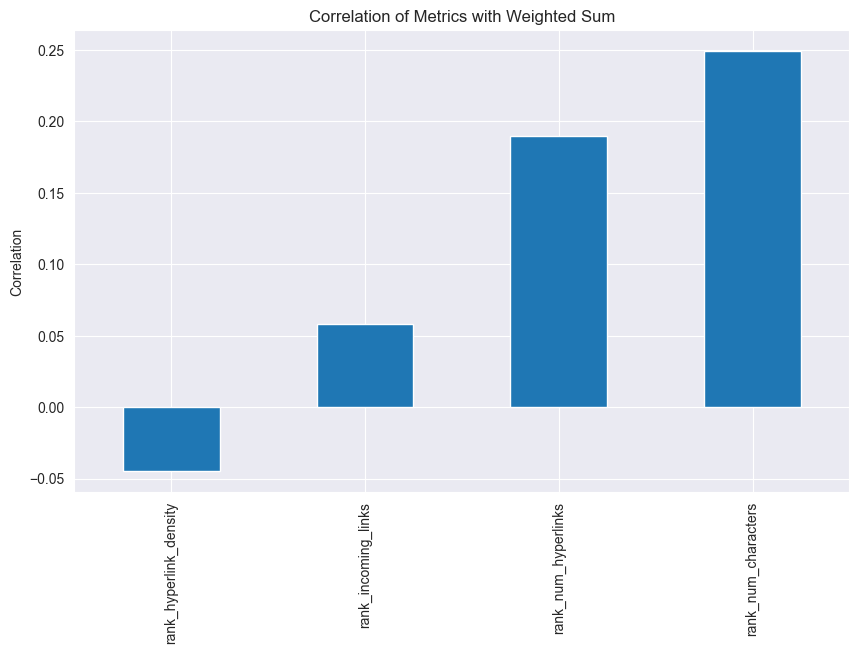

In [193]:
# Rank articles for each metric
combined_df['rank_incoming_links'] = combined_df['incoming_links'].rank(ascending=False)
combined_df['rank_num_hyperlinks'] = combined_df['num_hyperlinks'].rank(ascending=False)
combined_df['rank_num_characters'] = combined_df['num_characters'].rank(ascending=False)
combined_df['rank_hyperlink_density'] = combined_df['hyperlink_density'].rank(ascending=False)
combined_df['rank_weighted_sum'] = combined_df['weighted_sum'].rank(ascending=False)

# Compute correlations between ranks and weighted_sum
correlations = combined_df[
    ['rank_incoming_links', 'rank_num_hyperlinks', 'rank_num_characters', 'rank_hyperlink_density']
].corrwith(combined_df['rank_weighted_sum'])

# Display correlation results
print("Correlation between weighted_sum ranking and ranks of each metric:")
print(correlations)

# Visualize correlations
import matplotlib.pyplot as plt
correlations.sort_values().plot(kind='bar', figsize=(10, 6), title="Correlation of Metrics with Weighted Sum")
plt.ylabel("Correlation")
plt.show()

Interestingly the attribute of article that is the most strongly correlated to the weighted sum ranking of articles is the length of the article, also the hyperlink density is negatively correlated with the weighted sum ranking supposing that having very dense articles might loose the players and lead them to a suboptimal navigation.